In [1]:
import os
import json
from PIL import Image
from torch.utils.data import Dataset

# crop & disease map 정의
crop_map = {
    1: "가지",
    2: "고추",
    4: "딸기"
}
disease_map = {
    0: "정상",
    1: "가지원공팡이병",
    2: "가지흰가루병",
    3: "고추마일드모틀바이러스병",
    4: "고추점무늬병",
    7: "딸기잿빛곰팡이병",
    8: "딸기흰가루병"
}

class CropDiseaseDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.samples = []
        self.label_to_idx = {}

        for fname in os.listdir(label_dir):
            if not fname.endswith(".json"):
                continue
            label_path = os.path.join(label_dir, fname)
            with open(label_path, 'r', encoding='utf-8') as f:
                data = json.load(f)
                crop_id = data["annotations"]["crop"]
                disease_id = data["annotations"]["disease"]
                image_name = data["description"]["image"]
                label = f"{crop_map.get(crop_id, 'Unknown')}_{disease_map.get(disease_id, 'Unknown')}"
                self.samples.append((image_name, label))

        # 클래스 인덱스 생성
        all_labels = sorted(list(set([label for _, label in self.samples])))
        self.label_to_idx = {label: idx for idx, label in enumerate(all_labels)}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        image_name, label = self.samples[idx]
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label_idx = self.label_to_idx[label]
        return image, label_idx

In [2]:
import torch
from torchvision import transforms, models
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 전처리
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

# 데이터셋 & 로더
train_ds = CropDiseaseDataset("dataset/train/images", "dataset/train/labels", transform=transform)
val_ds = CropDiseaseDataset("dataset/val/images", "dataset/val/labels", transform=transform)

val_ds.label_to_idx = train_ds.label_to_idx  # 🎯 중요!

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=12)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=12)

# ViT 모델 로딩 (사전학습된 모델 사용)
model = models.vit_b_16(pretrained=True)
model.heads.head = nn.Linear(model.heads.head.in_features, len(train_ds.label_to_idx))

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 손실함수 & 옵티마이저
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)


/home/sojung/miniconda3/envs/test6/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sojung/miniconda3/envs/test6/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
num_epochs = 10
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    total, correct, train_loss = 0, 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = outputs.argmax(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(correct / total)

    # 검증
    model.eval()
    total, correct, val_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            preds = outputs.argmax(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(correct / total)

    print(f"Epoch [{epoch+1}/{num_epochs}] Train Acc: {train_accuracies[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}")


Epoch [1/10] Train Acc: 0.9787, Val Acc: 0.9609
Epoch [2/10] Train Acc: 0.9898, Val Acc: 0.9470
Epoch [3/10] Train Acc: 0.9921, Val Acc: 0.9743
Epoch [4/10] Train Acc: 0.9931, Val Acc: 0.9722
Epoch [5/10] Train Acc: 0.9935, Val Acc: 0.9481
Epoch [6/10] Train Acc: 0.9954, Val Acc: 0.9551
Epoch [7/10] Train Acc: 0.9950, Val Acc: 0.9636
Epoch [8/10] Train Acc: 0.9959, Val Acc: 0.9470
Epoch [9/10] Train Acc: 0.9954, Val Acc: 0.9497
Epoch [10/10] Train Acc: 0.9961, Val Acc: 0.9240


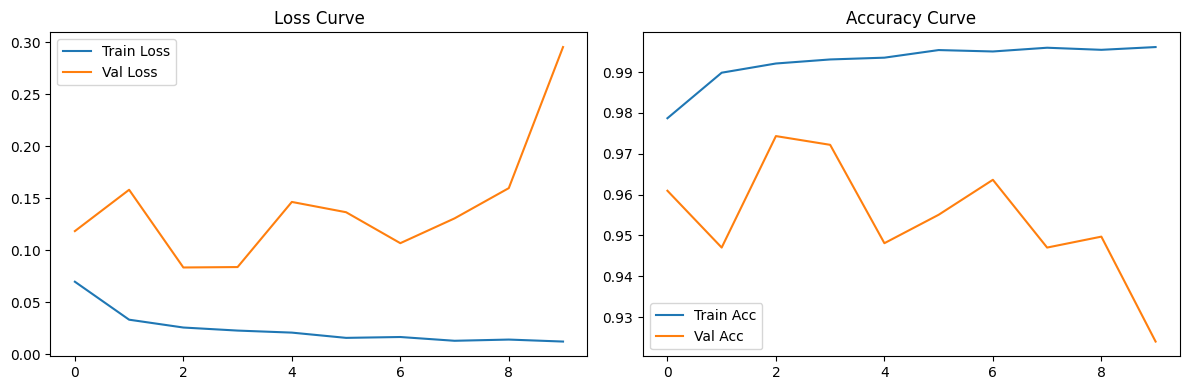

In [4]:
plt.figure(figsize=(12, 4))

# 손실
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve")
plt.legend()

# 정확도
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Val Acc")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()

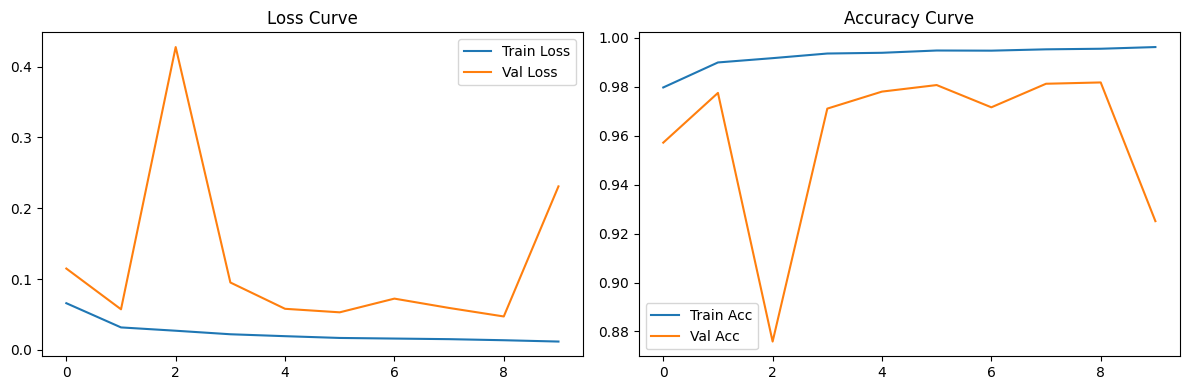

In [6]:
plt.figure(figsize=(12, 4))

# 손실
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss Curve")
plt.legend()

# 정확도
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(val_accuracies, label="Val Acc")
plt.title("Accuracy Curve")
plt.legend()

plt.tight_layout()
plt.show()